In [3]:
import PIL
from glob import glob
# %matplotlib inline
# Import libraries
import sys
import os
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf

batch_size = 16
x_train1 = np.array([np.array(PIL.Image.open(filename).convert('RGB').resize([64,64])) for filename in glob('data/cage/*')])/255
x_train2 = np.array([np.array(PIL.Image.open(filename).convert('RGB').resize([64,64])) for filename in glob('data/trump/*')])/255
x_valid1 = x_train1[-batch_size:]
x_valid2 = x_train2[-batch_size:]
x_train1 = x_train1[:-batch_size] #cage
x_train2 = x_train2[:-batch_size] #trump
print(x_train1.shape)
print(x_train2.shape)


def plot_imgs(imgs, n, title=None):
    fig, axs = plt.subplots(1, n, figsize=(n, 2))
    if n==1:
        axs = [axs]
    for i in range(n):
        axs[i].imshow(imgs[i], cmap='gray')
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    if title is not None:
        fig.suptitle(title)
    plt.show()


class AutoEncoder(object):
    def __init__(self, image_size, lr=0.001, cost_function='bce', optimizer='adadelta'):
        
        self.image_size = image_size
        self.lr = lr # learning rate
        self.cost_function = cost_function
        self.optimizer = optimizer
        self.build_model()
        
    def build_model(self):
        image_size = self.image_size
        self.encoder_input1 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='encoder_input1')
        self.encoder_input2 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='encoder_input2')
        self.decoder_output1 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='decoder_output1')
        self.decoder_output2 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='decoder_output2')
        
        
        def encoder(encoder_input):
            encoder_input = tf.reshape(encoder_input, [-1, image_size*image_size*3])
            with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
                # TODO: Complete encoder
                hidden = tf.layers.dense(inputs=encoder_input, units=2048, activation=tf.nn.relu)
                
                hidden = tf.layers.dense(hidden, units=512, activation=tf.nn.relu)
                hidden = tf.layers.dense(hidden, units=128, activation=tf.nn.relu)
                hidden = tf.layers.dense(hidden, units=16, activation=tf.nn.relu)
            return hidden
          
        self.encoded_embedding1 = encoder(self.encoder_input1)
        self.encoded_embedding2 = encoder(self.encoder_input2)
        
        def decoder(encoded_embedding, scope_name):   
            with tf.variable_scope(scope_name): 
                # TODO: Complete decoder 
                hidden = tf.layers.dense(inputs=encoded_embedding, units=128, activation=tf.nn.relu)
                
                hidden = tf.layers.dense(hidden, units=512, activation=tf.nn.relu)
                hidden = tf.layers.dense(hidden, units=2048, activation=tf.nn.relu)
                outputs = tf.layers.dense(hidden, units=image_size*image_size*3, name="op")
                print(tf.reshape(outputs, [-1, image_size,image_size,3]))
                return tf.reshape(outputs, [-1, image_size,image_size,3])
              
        outputs1 = decoder(self.encoded_embedding1, 'decoder1')
        outputs2 = decoder(self.encoded_embedding2, 'decoder2')
        
        ################## define cost function and optimizer ##################        
        if self.cost_function == 'mse':
            self.reconstruct_x1 = outputs1
            self.reconstruct_x2 = outputs2
            self.cost1 = tf.reduce_mean(tf.pow(self.decoder_output1-outputs1, 2))
            self.cost2 = tf.reduce_mean(tf.pow(self.decoder_output2-outputs2, 2))
        elif self.cost_function == 'bce':
            self.reconstruct_x1 = tf.nn.sigmoid(outputs1)
            self.reconstruct_x2 = tf.nn.sigmoid(outputs2)
            self.cost1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                            labels=self.decoder_output1, 
                                                            logits=outputs1))
            self.cost2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                            labels=self.decoder_output2, 
                                                            logits=outputs2))
        else:
            self.reconstruct_x1 = outputs1
            self.reconstruct_x2 = outputs2
            self.cost1 = tf.reduce_mean(tf.abs(self.decoder_output1-outputs1))
            self.cost2 = tf.reduce_mean(tf.abs(self.decoder_output2-outputs2))
            
        self.cost = self.cost1 + self.cost2    
        self.lr = tf.Variable(self.lr, trainable=False, name='learning_rate')
        if self.optimizer == 'adadelta':
            self.optimize_op = tf.train.AdadeltaOptimizer(self.lr).minimize(self.cost)
        elif self.optimizer == 'adam':
            self.optimize_op = tf.train.AdamOptimizer(self.lr, beta1=0.5).minimize(self.cost)
        elif self.optimizer == 'rmsprop':
            self.optimize_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.cost)
        else:
            raise NotImplementedError
            
    def train(self, sess, x_train1, x_train2, x_train1_output, x_train2_output, 
              x_valid1, x_valid2, x_valid1_output, x_valid2_output, n_epoch=200, batch_size=100, patience=5):
        t0 = time()
        train_costs_per_epoch = []
        valid_costs_per_epoch = []
        best_cost = np.inf
        counter = 0
        def iter_data(*data, **kwargs):
            size = kwargs.get('batch_size', 32)
            try:
                n = len(data[0])
            except:
                n = data[0].shape[0]
            batches = int(n / size)
            if n % size != 0:
                batches += 1

            for b in range(batches):
                start = b * size
                end = (b + 1) * size
                if end > n:
                    end = n
                if len(data) == 1:
                    yield data[0][start:end]
                else:
                    yield tuple([d[start:end] for d in data])
        for epoch in (range(n_epoch)):
            t = time()
            data_to_use = min(len(x_train1), len(x_train2))
            shuffle_idx = np.random.permutation(len(x_train1))
            x_train1 = x_train1[shuffle_idx][:data_to_use]
            x_train1_output = x_train1_output[shuffle_idx][:data_to_use]
            shuffle_idx = np.random.permutation(len(x_train2))
            x_train2 = x_train2[shuffle_idx][:data_to_use]
            x_train2_output = x_train2_output[shuffle_idx][:data_to_use]
            train_costs1 = []
            train_costs2 = []
            train_costs = []
            valid_costs1 = []
            valid_costs2 = []
            valid_costs = []
            
            # train
            for input1_batch, input2_batch, output1_batch, output2_batch in iter_data(x_train1, x_train2, x_train1_output, x_train2_output, batch_size=batch_size):
                feed_dict = {
                    self.encoder_input1: input1_batch, 
                    self.decoder_output1: output1_batch,
                    self.encoder_input2: input2_batch, 
                    self.decoder_output2: output2_batch,
                    self.lr: 5e-5,
                }
                _, cost1, cost2, cost = sess.run([self.optimize_op, self.cost1, self.cost2, self.cost], feed_dict=feed_dict)
                train_costs1.append(cost1)
                train_costs2.append(cost2)
                train_costs.append(cost)
#             print('epoch{}, cost: {:.4f}, train_cost1: {:.4f}, train_cost2: {:.4f}, time_passed: {}'.format(
#                   epoch, np.mean(train_costs), np.mean(train_costs1), np.mean(train_costs2), time()-t))
            train_costs_per_epoch.append(np.mean(train_costs))
            
            # validation
            for input1_batch, input2_batch, output1_batch, output2_batch in iter_data(x_valid1, x_valid2, x_valid1_output, x_valid2_output, batch_size=batch_size):
                feed_dict = {
                    self.encoder_input1: input1_batch, 
                    self.decoder_output1: output1_batch,
                    self.encoder_input2: input2_batch, 
                    self.decoder_output2: output2_batch,
                }
                cost1, cost2, cost = sess.run([self.cost1, self.cost2, self.cost], feed_dict=feed_dict)
                valid_costs1.append(cost1)
                valid_costs2.append(cost2)
                valid_costs.append(cost)
#             print('epoch{}, valid_cost: {:.4f}, valid_cost1: {:.4f}, valid_cost2: {:.4f}, time_passed: {}'.format(
#                   epoch, np.mean(valid_costs), np.mean(valid_costs1), np.mean(valid_costs2), time()-t))
            valid_costs_per_epoch.append(np.mean(valid_costs))
#             plt.subplot(1,2,1)
#             plt.plot(train_costs_per_epoch)
            
#             plt.subplot(1,2,2)
#             plt.plot(valid_costs_per_epoch)
#             plt.show()
            # for every 50 epoch, plot image
            if epoch > 0 and epoch % 50 == 0:
                print('epoch: {}'.format(epoch))
                n = 10
                orig_imgs = x_train1[:n]
                recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
                min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(min_value < 0, recon_imgs-min_value, recon_imgs)
                max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)
                recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
                min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(min_value < 0, recon_imgs2-min_value, recon_imgs2)
                max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
                plot_imgs(orig_imgs, n=n, title='Test Samples')
                plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
                plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')

                orig_imgs = x_train2[:n]
                recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
                min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(min_value < 0, recon_imgs-min_value, recon_imgs)
                max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)
                recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
                min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(min_value < 0, recon_imgs2-min_value, recon_imgs2)
                max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
                
            # early stop
            if best_cost > np.mean(valid_costs):
                best_cost = np.mean(valid_costs)
                counter = 0
            else:
                counter += 1
            if counter >= patience:
                print('early stop at {} epoch'.format(epoch))
                break
        return train_costs_per_epoch, valid_costs_per_epoch
            
    def encode(self, sess, inputs, use_decoder1=True):
        if use_decoder1:
            return sess.run(self.encoded_embedding1, feed_dict={self.encoder_input1: inputs})
        else:
            return sess.run(self.encoded_embedding2, feed_dict={self.encoder_input2: inputs})
          
    def reconstruct(self, sess, inputs, use_decoder1=True):
        if use_decoder1:
            return sess.run(self.reconstruct_x1, feed_dict={self.encoder_input1: inputs})
        else:
            return sess.run(self.reconstruct_x2, feed_dict={self.encoder_input2: inputs})
    
tf.reset_default_graph()
np.random.seed(123)
tf.set_random_seed(123)
autoencoder = AutoEncoder(image_size=64, optimizer='rmsprop', lr=0.02, cost_function='bce')





(302, 64, 64, 3)
(360, 64, 64, 3)
Tensor("decoder1/Reshape:0", shape=(?, 64, 64, 3), dtype=float32)
Tensor("decoder2/Reshape:0", shape=(?, 64, 64, 3), dtype=float32)


epoch: 50


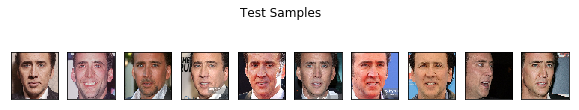

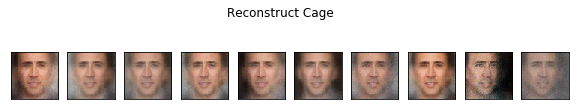

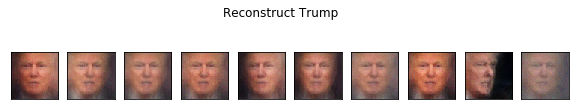

epoch: 100


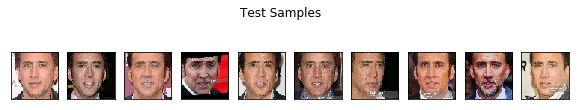

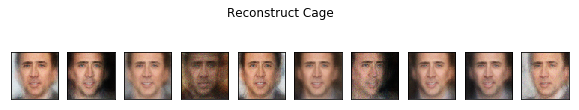

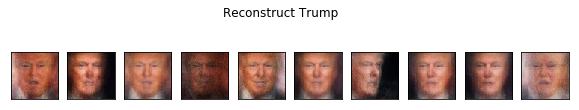

epoch: 150


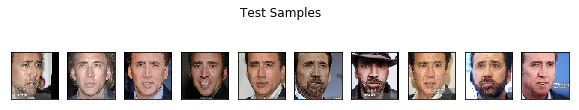

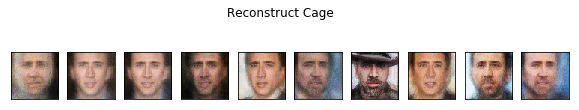

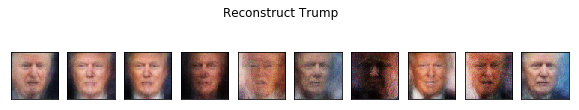

epoch: 200


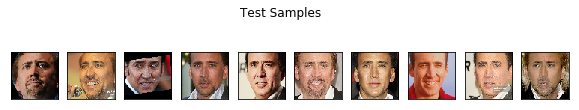

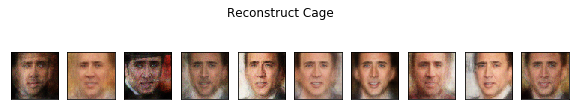

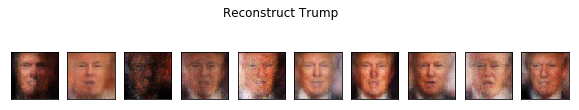

early stop at 228 epoch


In [4]:

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

#def train(self, sess, x_train1, x_train2, x_train1_output, x_train2_output, 
              #x_valid1, x_valid2, x_valid1_output, x_valid2_output, n_epoch=200, batch_size=100, patience=5):
train_costs_per_epoch = autoencoder.train(sess, x_train1, x_train2, x_train1, x_train2, 
                                          x_valid1, x_valid2, x_valid1, x_valid2, n_epoch=1000, batch_size=batch_size, patience=20)



# report

After finding some website,I realize that autoencoder can be a tool of feature extraction and dimentionality reduction.Also,I can use it AE to pretrain my model for helping deep learning model to learn.
reference:https://medium.com/@elsalin0919/autoencoder-%E6%88%91%E5%B0%8D%E4%B8%8D%E8%B5%B7%E4%BD%A0%E4%B9%8B-%E9%87%8D%E6%96%B0%E8%AA%8D%E8%AD%98autoencoder-%E7%AC%AC%E4%B8%80%E7%AF%87-d970d1ad9971

http://www.jmlr.org/papers/volume11/erhan10a/erhan10a.pdf

In this homework,I simply write a encoder and decoder ,which need a reshaped data.

thanks TA for this easy task.